<a href="https://colab.research.google.com/github/cyrus2281/notes/blob/main/MachineLearning/Tensorflow/LazyProgrammer/04_Tensorflow_Applied_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content

>[Content](#updateTitle=true&folderId=1tQy5G8Ez_uC7IO_awAeU041TrL-36P3f&scrollTo=ePHlhAaEOHMC)

>[Natural Language Processing](#updateTitle=true&folderId=1tQy5G8Ez_uC7IO_awAeU041TrL-36P3f&scrollTo=ersh2wz5N-z4)

>>[One-Hot Encoding](#updateTitle=true&folderId=1tQy5G8Ez_uC7IO_awAeU041TrL-36P3f&scrollTo=S3oLgDxGOwtH)

>>[Embedding](#updateTitle=true&folderId=1tQy5G8Ez_uC7IO_awAeU041TrL-36P3f&scrollTo=xonkFyf1Q_Mf)

>>>[Python Implementation](#updateTitle=true&folderId=1tQy5G8Ez_uC7IO_awAeU041TrL-36P3f&scrollTo=KqcZ2g6iSfoQ)

>>[Spam Detection with RNN](#updateTitle=true&folderId=1tQy5G8Ez_uC7IO_awAeU041TrL-36P3f&scrollTo=QlcR2gJLXCq9)

>>[Spam Detection with 1-D CNN](#updateTitle=true&folderId=1tQy5G8Ez_uC7IO_awAeU041TrL-36P3f&scrollTo=wjD0HKjuZaMa)

>[Recommender System](#updateTitle=true&folderId=1tQy5G8Ez_uC7IO_awAeU041TrL-36P3f&scrollTo=k9DiUrAoeg_p)



# Natural Language Processing

Natural Language Processing (NLP)

Given a sentence as an input, we can't perform matrix manipulations on them.



## One-Hot Encoding

Using an array of zeros the size of our language dictionary, and set the index for each word to one.

This raises an issues as there could be millions of tokens/words in a language, so the input and the input-hidden wieght matrix will be too large.

This data also has no geometrical infrastructure.


- ["I", "like", "dogs"] ⇒ [[0⋯,1,⋯0], [0⋯,1,⋯0], [0⋯,1,⋯0]]

## Embedding

One-hot encoding an integer k and multiplying that by a matrix is the same as selecting the k'th row of the matrix

$$
\text{one_hot}(k) × W == W[k] \\
\begin{bmatrix}
1 & 0 & 0
\end{bmatrix}
\times
\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}
=
\begin{bmatrix}
1 & 2 & 3
\end{bmatrix}
$$

So instead of creating a one-hot encoded matrix, we can just create an embedding matrix and access the row by k. This is what the **Embedding layer** in Tensorflow does.

- ["I", "like", "dogs"] ⇒ [50, 23, 8]

Use integersto index the word embedding matrix to get word vectors for each word

- [50, 23, 8] ⇒ [[0.3, -0.5], [1.2, 0.8], [-2.1, 0.9]]

T-length array → T×D matrix

These weights get trained automatically by the neural network



### Python Implementation

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

We don't use 0 for embedding as it is used for padding

In [2]:
# Just a sample test
sentences = [
  "I like eggs and ham.",
  "I love chocolate and milk.",
  "I hate broccoli."
]

In [3]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [4]:
print(sequences)

[[1, 3, 4, 2, 5], [1, 6, 7, 2, 8], [1, 9, 10]]


In [5]:
# How to get the word to index mapping
tokenizer.word_index

{'i': 1,
 'and': 2,
 'like': 3,
 'eggs': 4,
 'ham': 5,
 'love': 6,
 'chocolate': 7,
 'milk': 8,
 'hate': 9,
 'broccoli': 10}

In [6]:
# use the defaults
data = pad_sequences(sequences)
print(data)

[[ 1  3  4  2  5]
 [ 1  6  7  2  8]
 [ 0  0  1  9 10]]


In [7]:
data = pad_sequences(sequences, maxlen=5)
print(data)

[[ 1  3  4  2  5]
 [ 1  6  7  2  8]
 [ 0  0  1  9 10]]


In a situation like spam detection, pre padding is better because the LSTM won't be forgetting the data.

But in a case like language translation, post padding is better because if it starts with zero, the model wouldn't know what to translate.

In [8]:
data = pad_sequences(sequences, maxlen=5, padding='post')
print(data)

[[ 1  3  4  2  5]
 [ 1  6  7  2  8]
 [ 1  9 10  0  0]]


In [9]:
# Extra padding
data = pad_sequences(sequences, maxlen=6)
print(data)

[[ 0  1  3  4  2  5]
 [ 0  1  6  7  2  8]
 [ 0  0  0  1  9 10]]


In [10]:
# Truncation
data = pad_sequences(sequences, maxlen=4, truncating="pre")
print(data)

[[ 3  4  2  5]
 [ 6  7  2  8]
 [ 0  1  9 10]]


## Spam Detection with RNN

In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [13]:
# Unfortunately this URL doesn't work directory with pd.read_csv
!wget https://lazyprogrammer.me/course_files/spam.csv

--2023-12-20 03:56:19--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  1.35MB/s    in 0.4s    

2023-12-20 03:56:21 (1.35 MB/s) - ‘spam.csv’ saved [503663/503663]



In [14]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [15]:
# Drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
# Rename columns to something better
df.columns = ['labels', 'data']

df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
# Create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [18]:
# Split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [19]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [20]:
# Get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' %V)

Found 7226 unique tokens.


In [21]:
# Pad sequences so that get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor: ', data_train.shape)

# Get sequence length
T = data_train.shape[1]

Shape of data train tensor:  (3733, 189)


In [22]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor: ', data_test.shape)

Shape of data test tensor:  (1839, 189)


Training model...
Epoch 1/10
117/117 [==============================] - 21s 135ms/step - loss: 0.4779 - accuracy: 0.8508 - val_loss: 0.3259 - val_accuracy: 0.8608
Epoch 2/10
117/117 [==============================] - 8s 71ms/step - loss: 0.2459 - accuracy: 0.8685 - val_loss: 0.2164 - val_accuracy: 0.8608
Epoch 3/10
117/117 [==============================] - 4s 36ms/step - loss: 0.1738 - accuracy: 0.9153 - val_loss: 0.1570 - val_accuracy: 0.9788
Epoch 4/10
117/117 [==============================] - 3s 23ms/step - loss: 0.1255 - accuracy: 0.9912 - val_loss: 0.1222 - val_accuracy: 0.9859
Epoch 5/10
117/117 [==============================] - 3s 23ms/step - loss: 0.0964 - accuracy: 0.9952 - val_loss: 0.1025 - val_accuracy: 0.9864
Epoch 6/10
117/117 [==============================] - 4s 32ms/step - loss: 0.0782 - accuracy: 0.9962 - val_loss: 0.0885 - val_accuracy: 0.9886
Epoch 7/10
117/117 [==============================] - 3s 24ms/step - loss: 0.0650 - accuracy: 0.9971 - val_loss: 0.0795 - 

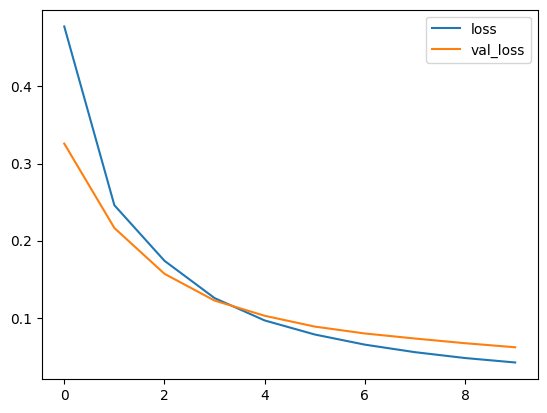

In [23]:
# Create the model

# Get to choose embedding dimensionality
D = 20

# Hidden state dimensionality
M = 15

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

# Compile and fit
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print('Training model...')
r = model.fit(
    data_train,
    Ytrain,
    epochs=10,
    validation_data =(data_test, Ytest)
)

# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

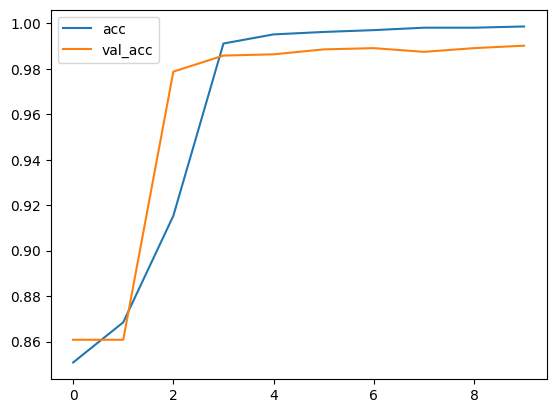

In [24]:
# PLot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

## Spam Detection with 1-D CNN

1-D convolution (or cross-correlation)

$$
x(t) × w(t) = \sum_\tau x(t+\tau)w(\tau) \\
$$

1-D convolution with features


$$
y(t,m) = \sum_\tau \sum_{d=1}^D x(t+\tau, d)w(\tau, d, m) \\
$$

- Input is T×D (T= number of time steps, D = number of input features)
- Output is T×M (M= number of output features)
- Then W (the filter) has the shape T'×D×M (Where T' << T)

- For images
  - 2 spatial dimensions + 1 input feature dimension + 1 output feature dimension = 4
  - 1 spatial dimensions + 1 input feature dimension + 1 output feature dimension = 3

In [25]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

In [26]:
# Unfortunately this URL doesn't work directory with pd.read_csv
!wget https://lazyprogrammer.me/course_files/spam.csv

--2023-12-20 04:05:53--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv.1’

spam.csv.1          100%[===================>] 491.86K  1.23MB/s    in 0.4s    

2023-12-20 04:05:55 (1.23 MB/s) - ‘spam.csv.1’ saved [503663/503663]



In [27]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

# Drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

# Rename columns to something better
df.columns = ['labels', 'data']

df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [28]:
# Create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [29]:
# Split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [30]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [32]:
# Get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' %V)

# Pad sequences so that get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor: ', data_train.shape)

# Get sequence length
T = data_train.shape[1]

data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor: ', data_test.shape)

Found 7177 unique tokens.
Shape of data train tensor:  (3733, 189)
Shape of data test tensor:  (1839, 189)


In [33]:
# Create the model

# Get to choose embedding dimensionality
D = 20


i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

# Compile and fit
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print('Training model...')
r = model.fit(
    data_train,
    Ytrain,
    epochs=5,
    validation_data =(data_test, Ytest)
)

Training model...
Epoch 1/5
117/117 [==============================] - 18s 124ms/step - loss: 0.3996 - accuracy: 0.8607 - val_loss: 0.2949 - val_accuracy: 0.8657
Epoch 2/5
117/117 [==============================] - 9s 72ms/step - loss: 0.1494 - accuracy: 0.9333 - val_loss: 0.0785 - val_accuracy: 0.9804
Epoch 3/5
117/117 [==============================] - 5s 42ms/step - loss: 0.0244 - accuracy: 0.9944 - val_loss: 0.0766 - val_accuracy: 0.9853
Epoch 4/5
117/117 [==============================] - 4s 32ms/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 0.0872 - val_accuracy: 0.9837
Epoch 5/5
117/117 [==============================] - 3s 30ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.0769 - val_accuracy: 0.9864


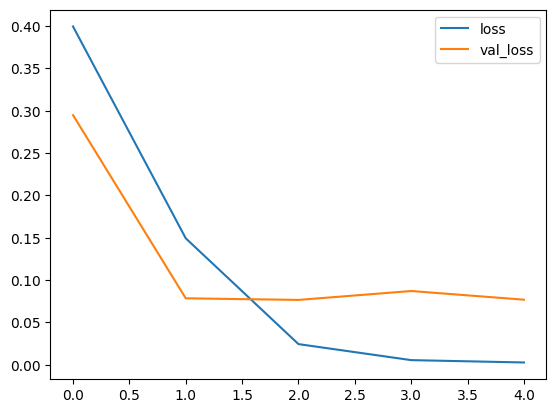

In [34]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

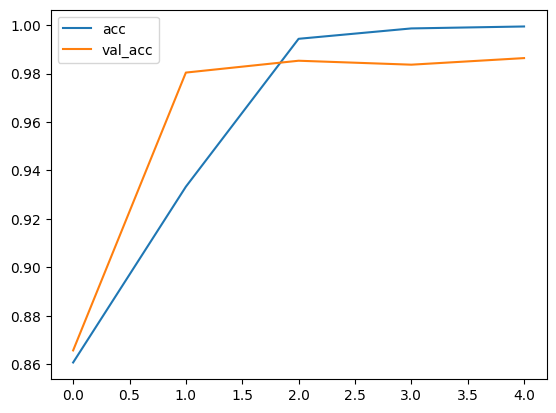

In [35]:
# PLot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [53]:
test_sentence= np.array([
    "Congratulation, you have won 1 million dollars, Click on the link to accept!",
    "Hey John, this is alex. ping me when available"
])

test_seq = tokenizer.texts_to_sequences(test_sentence)
test_data = pad_sequences(test_seq, maxlen=T)

preds = model.predict(test_data)
preds = np.round(preds)

# 1 = spam  0 = ham
preds

1/1 [==============================] - 0s 28ms/step


array([[1.],
       [0.]], dtype=float32)

# Recommender System

In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [55]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip
!unzip -n ml-20m.zip

--2023-12-20 04:27:52--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  13.5MB/s    in 16s     

2023-12-20 04:28:08 (12.2 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [56]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [57]:
# The userId and movieId to be numbered 0...N-1

# current_user_id = 0
# custom_user_map = {} # old user id > new user id
# def map_user_id(row):
#   global current_user_id, custom_user_map
#   old_user_id = row['userId']
#   if old_user_id not in custom_user_map:
#     custom_user_map[old_user_id] = current_user_id
#     current_user_id += 1
#   return custom_user_map[old_user_id]
# df['new_user_id'] = df.apply(map_user_id, axis=1)

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [58]:
# Now do same things for movie ids

# current_user_id = 0
# custom_user_map = {} # old user id > new user id
# def map_user_id(row):
#   global current_user_id, custom_user_map
#   old_user_id = row['userId']
#   if old_user_id not in custom_user_map:
#     custom_user_map[old_user_id] = current_user_id
#     current_user_id += 1
#   return custom_user_map[old_user_id]
# df['new_user_id'] = df.apply(map_user_id, axis=1)

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [60]:
# Get user IDs, movie IDs and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values

In [61]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
K = 10

In [62]:
# Make a neural network

# User input
u = Input(shape=(1,))

# Movie input
m = Input(shape=(1,))

# User embedding
u_emb = Embedding(N, K)(u) # Output is (num_samples, 1, K)

# Movie embedding
m_emb = Embedding(M, K)(m) # Output is (num_samples, 1, K)

# Flatten both embeddings
u_emb = Flatten()(u_emb) # Now it's (num_samples, K)
m_emb = Flatten()(m_emb) # Now it's (num_samples, K)

# Concatenate user-movie embeddings into a feature vector
x = Concatenate()([u_emb, m_emb]) # Now it's (num_samples, 2K)

# Feature vector regular ANN
x = Dense(1024, activation='relu')(x)
# x = Dense(400, activation='relu')(x)
# x = Dense(400, activation='relu')(x)
x = Dense(1)(x)


# Build the model and compile
model = Model(inputs=[u, m], outputs=x)
model.compile(
    loss='mse',
    optimizer=SGD(learning_rate=0.08, momentum=0.9),
)

In [63]:
# Split the data
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[:Ntrain]
test_movie = movie_ids[:Ntrain]
test_ratings = ratings[:Ntrain]

# Center the ratings
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

In [ ]:
r = model.fit(
    x = [train_user, train_movie],
    y = [train_ratings],
    epochs=25,
    batch_size = 1024,
    verbose='',
    validation_data=([test_user, test_movie], test_ratings),
)

# Plot losses
plt.plot(r.history['loss'], label='train_loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()